In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Concatenate
from keras.layers import Input
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,Flatten,BatchNormalization,Input
from tensorflow.keras.applications import MobileNetV2, DenseNet169
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2025-04-09 09:13:25.958502: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 09:13:25.958948: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-09 09:13:25.961466: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-09 09:13:25.968396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744179205.979815  584486 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744179205.98

creating a dual-branch input model that feeds the image into both MobileNetV2 and DenseNet169 (excluding their top layers).

In [3]:
input_shape=(224,224,3)
input_layer=Input(shape=(224,224,3))
mobilenet_base = MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)

densenet_base = DenseNet169(weights='imagenet', input_shape=input_shape, include_top=False)

E0000 00:00:1744179207.481763  584486 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1744179207.492890  584486 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
mobilenet_base.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

freeze the convolutional layers to avoid training them again — this is classic transfer learning.

In [5]:
CLASSES=2

for layer in mobilenet_base.layers:
    layer.trainable=False

for layer in densenet_base.layers:
    layer.trainable=False

    
#combining (stacking) the features extracted by both models into a single layer.
model_mobilenet=mobilenet_base(input_layer)
model_mobilenet2=GlobalAveragePooling2D()(model_mobilenet)
output_mobilenet=Flatten()(model_mobilenet2)

model_densenet=densenet_base(input_layer)
model_densenet2=GlobalAveragePooling2D()(model_densenet)
output_densenet=Flatten()(model_densenet2)

merged=Concatenate()([output_mobilenet,output_densenet])
#After merging, it passes through a few fully connected layers, 
#regularized with Dropout and BatchNorm to prevent overfitting.
x = BatchNormalization()(merged)
x = Dense(256,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(CLASSES, activation = 'softmax')(x)
stacked_model = tf.keras.models.Model(inputs = input_layer, outputs = x)

Defines and compiles the model for multi-class classification (with CLASSES=2).

In [6]:
stacked_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
stacked_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet169         │ (None, 7, 7,      │ 12,642,880 │ input_layer[0][0] │
│ (Functional)        │ 1664)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1664)      │          0 │ densenet169[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1664)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2944)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2944)      │     11,776 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    753,920 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        258 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,700,738 (59.89 MB)

 Trainable params: 793,474 (3.03 MB)

 Non-trainable params: 14,907,264 (56.87 MB)

In [8]:
os.listdir('/home/db21160/Desktop/test')


['PNEUMONIA', 'NORMAL']

In [9]:
WIDTH = 224
HEIGHT = 224
BATCH_SIZE = 32
TRAIN_DIR=r'/home/db21160/Desktop/train'
VAL_DIR=r'/home/db21160/Desktop/val'
TEST_DIR=r'/home/db21160/Desktop/test'
# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
#augment the images to make the model more robust to different orientations, scales, flips, etc.
#Loads images from directories and applies augmentation + preprocessing.
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


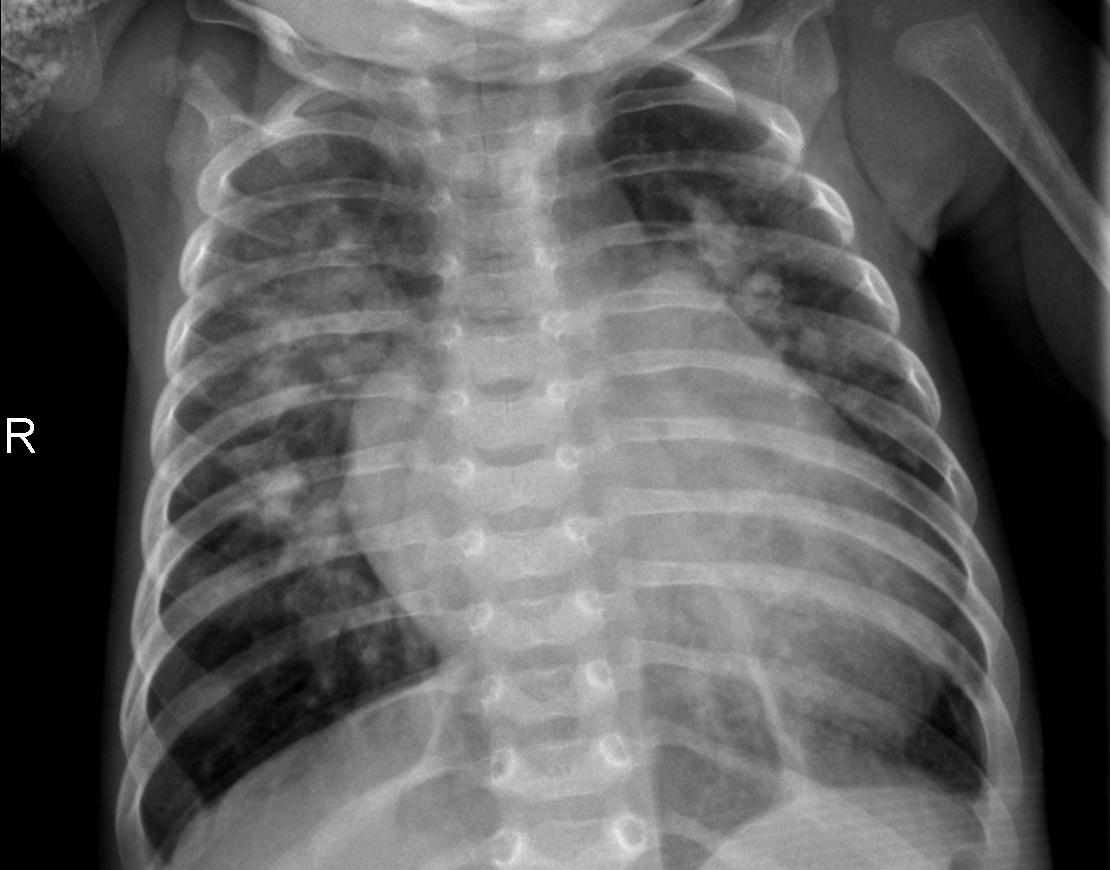

In [10]:
image.load_img('/home/db21160/Desktop/test/PNEUMONIA/person91_bacteria_445.jpeg')

In [11]:
EPOCHS = 20
BATCH_SIZE = 32
STEPS_PER_EPOCH = train_generator.n//train_generator.batch_size
VALIDATION_STEPS=validation_generator.n//train_generator.batch_size
STEPS_PER_EPOCH,VALIDATION_STEPS

(163, 0)

In [12]:
stacked_model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,verbose=1)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 162s 939ms/step - accuracy: 0.8552 - loss: 0.3507 - val_accuracy: 0.7500 - val_loss: 0.7721
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 148s 908ms/step - accuracy: 0.9436 - loss: 0.1479 - val_accuracy: 0.8750 - val_loss: 0.4609
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 155s 948ms/step - accuracy: 0.9453 - loss: 0.1306 - val_accuracy: 0.9375 - val_loss: 0.1751
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 152s 931ms/step - accuracy: 0.9456 - loss: 0.1393 - val_accuracy: 0.8125 - val_loss: 0.2790
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 150s 919ms/step - accuracy: 0.9594 - loss: 0.1149 - val_accuracy: 0.9375 - val_loss: 0.2041
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 156s 952ms/step - accuracy: 0.9551 - loss: 0.1196 - val_accuracy: 0.8750 - val_loss: 0.5968
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 893ms/step - accuracy: 0.9602 - loss: 0.0989 - val_accuracy: 0.8750 - val_loss: 0.3414
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9613 - lo

In [13]:
img = image.load_img(r'/home/db21160/Desktop/test/PNEUMONIA/person91_bacteria_445.jpeg', target_size=(224, 224,3))
x = image.img_to_array(img)
x = preprocess_input(x)
x = np.expand_dims(x, axis=0)
pred = stacked_model.predict(x)[0]
print(pred)
print(train_generator.class_indices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[0.03573861 0.96426135]
{'NORMAL': 0, 'PNEUMONIA': 1}
